# Day 1 Notebook: Predicting Toronto's Weather

## Introduction

Toronto’s weather can be notoriously unpredictable, especially when planning outdoor events. In this project, we’ll build a time-series forecasting model to predict the temperature at least a week or two in advance. By the end of our journey, we’ll integrate this model into a Spring Boot backend, create a React frontend, and deploy everything on AWS S3. But for **Day 1**, our primary goal is to:

1. Load and explore our **Toronto weather dataset**  
2. Clean and manipulate the data as needed  
3. Build a **simple baseline** TensorFlow model (a toy model)  
4. Compile and evaluate this model  

This baseline will serve as our starting point, and we’ll improve upon it in the upcoming days (e.g., adding time-series techniques like LSTM).

---

## Lazy Programmer’s Approach

1. Load the data  
2. Manipulate the data  
3. Build the model  
4. Compile the model  
5. Evaluate the model  

We’ll follow these steps in this notebook. Once completed, we’ll have our initial results ready to **push to GitHub**.

---

In [1]:

## 0. Imports & Setup
# Install missing libraries
%pip install pandas numpy matplotlib tensorflow scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For scikit-learn baseline or metrics if needed
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make matplotlib plots inline
%matplotlib inline

print("Notebook environment set up. TensorFlow version:", tf.__version__)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\wafee\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Notebook environment set up. TensorFlow version: 2.19.0


## Load In Data From https://toronto.weatherstats.ca
The data provided is a CSV  (10K Rows) of various weather details based in Toronto in the past 20 or so years. 
We will: 
* Clean and Prepare the Data for our Simple Model (Linear Regression)
* Load Our Data Into A Pandas DataFrame (CSV)
* Drop Irrelevant/Empty/Unfinished Columns from the DataFrame For Our Purposes
* Fill in any columns of interest with the mean (if they have minimal unfinished entries)
* Sort the Rows By Date For Our Time Series
* Define Basic Features and Target Values

In [2]:
#Lets Load Our Data, and Get Some Cleaning And Preprocessing Done
# Load the dataset

df = pd.read_csv("./DailyWeatherStats.csv", parse_dates=['date'])
print("Data Loaded, Shape:", df.shape)
df.head()

Data Loaded, Shape: (10000, 72)


C:\Users\wafee\AppData\Local\Temp\ipykernel_22904\3248805573.py:4: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./DailyWeatherStats.csv", parse_dates=['date'])


,date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,...,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
0,2025-04-04,11.0,5.79,5.90,0.8,NaN,NaN,73,56.5,57.0,...,NaN,NaN,8.0,4.6,4.5,1.0,NaN,NaN,NaN,NaN
1,2025-04-03,20.0,11.41,11.80,3.6,NaN,NaN,100,73.1,72.0,...,NaN,NaN,8.0,6.7,5.5,3.0,NaN,NaN,NaN,NaN
2,2025-04-02,4.7,0.18,1.50,-1.7,NaN,-9.0,100,77.0,70.0,...,NaN,NaN,8.0,8.0,7.5,7.0,NaN,NaN,NaN,NaN
3,2025-04-01,3.7,0.79,0.90,-1.9,NaN,-6.0,79,48.8,53.5,...,NaN,NaN,8.0,3.9,4.5,1.0,NaN,NaN,NaN,NaN
4,2025-03-31,12.0,5.16,6.25,0.5,NaN,NaN,100,82.4,81.0,...,NaN,NaN,8.0,7.6,5.0,2.0,NaN,NaN,NaN,NaN


## Identify Columns With Missing Values (NaN)

In [3]:
#Lets Check and Clean Missing Values
#Validate Data Struucture, and Remove any Unwanted Columns 
df.info()
df.isna().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           10000 non-null  datetime64[ns]
 1   max_temperature                10000 non-null  float64       
 2   avg_hourly_temperature         10000 non-null  float64       
 3   avg_temperature                10000 non-null  float64       
 4   min_temperature                10000 non-null  float64       
 5   max_humidex                    2837 non-null   float64       
 6   min_windchill                  3309 non-null   float64       
 7   max_relative_humidity          10000 non-null  int64         
 8   avg_hourly_relative_humidity   10000 non-null  float64       
 9   avg_relative_humidity          10000 non-null  float64       
 10  min_relative_humidity          10000 non-null  int64         
 11  max_dew_point   

solar_radiation              10000
avg_hourly_cloud_cover_4     10000
avg_cloud_cover_4            10000
max_cloud_cover_4            10000
min_cloud_cover_4            10000
avg_hourly_cloud_cover_10     9763
avg_cloud_cover_10            9763
min_cloud_cover_10            9763
max_cloud_cover_10            9763
max_health_index              9760
avg_health_index              9760
avg_hourly_health_index       9760
min_health_index              9760
max_humidex                   7163
min_windchill                 6691
min_uv_forecast               6562
max_uv_forecast               6562
sunset_unixtime               5888
sunrise_unixtime              5888
sunset_hhmm                   5888
dtype: int64

Lets keep columns with info that we're interested in, or that are filled with values (good data)
Lets also fill in any missing data in our columns of interest with the mean data. 

In [4]:
#Drop Columns w/ Non Null Values, and Values We Aren't Interested In for Our Model 
keep_cols = [
    "date",
    "max_temperature",
    "avg_hourly_temperature",
    "avg_temperature",
    "min_temperature",
    "max_relative_humidity",
    "avg_hourly_relative_humidity",
    "avg_relative_humidity",
    "min_relative_humidity",
    "max_dew_point",
    "avg_hourly_dew_point",
    "avg_dew_point",
    "min_dew_point",
    "max_wind_speed",
    "avg_hourly_wind_speed",
    "avg_wind_speed",
    "min_wind_speed",
    "max_pressure_sea",
    "avg_hourly_pressure_sea",
    "avg_pressure_sea",
    "min_pressure_sea",
    "max_pressure_station",
    "avg_hourly_pressure_station",
    "avg_pressure_station",
    "min_pressure_station",
    "max_visibility",
    "avg_hourly_visibility",
    "avg_visibility",
    "min_visibility",
    "heatdegdays",
    "cooldegdays",
    "growdegdays_5",
    "growdegdays_7",
    "growdegdays_10",
    "precipitation",     # 9974 non-null
    "rain",              # 9962 non-null
    "snow"               # 9972 non-null
]
df = df[keep_cols]
df.isna().sum()

#Fill Missing Values with mean of the column
df['precipitation'].fillna(df['precipitation'].mean(), inplace=True) 
df['rain'].fillna(df['rain'].mean(), inplace=True) 
df['snow'].fillna(df['snow'].mean(), inplace=True) 
df.isna().sum()

C:\Users\wafee\AppData\Local\Temp\ipykernel_22904\696592791.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['precipitation'].fillna(df['precipitation'].mean(), inplace=True)
C:\Users\wafee\AppData\Local\Temp\ipykernel_22904\696592791.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

date                            0
max_temperature                 0
avg_hourly_temperature          0
avg_temperature                 0
min_temperature                 0
max_relative_humidity           0
avg_hourly_relative_humidity    0
avg_relative_humidity           0
min_relative_humidity           0
max_dew_point                   0
avg_hourly_dew_point            0
avg_dew_point                   0
min_dew_point                   0
max_wind_speed                  0
avg_hourly_wind_speed           0
avg_wind_speed                  0
min_wind_speed                  0
max_pressure_sea                0
avg_hourly_pressure_sea         0
avg_pressure_sea                0
min_pressure_sea                0
max_pressure_station            0
avg_hourly_pressure_station     0
avg_pressure_station            0
min_pressure_station            0
max_visibility                  0
avg_hourly_visibility           0
avg_visibility                  0
min_visibility                  0
heatdegdays   

In [5]:
df.info() #Verify Data Cleanup

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          10000 non-null  datetime64[ns]
 1   max_temperature               10000 non-null  float64       
 2   avg_hourly_temperature        10000 non-null  float64       
 3   avg_temperature               10000 non-null  float64       
 4   min_temperature               10000 non-null  float64       
 5   max_relative_humidity         10000 non-null  int64         
 6   avg_hourly_relative_humidity  10000 non-null  float64       
 7   avg_relative_humidity         10000 non-null  float64       
 8   min_relative_humidity         10000 non-null  int64         
 9   max_dew_point                 10000 non-null  float64       
 10  avg_hourly_dew_point          10000 non-null  float64       
 11  avg_dew_point                

In [6]:
#Lets Sort Our Data By Date, Since We're Going to be implmeenting a Time Series Model Eventually
df = df.sort_values(by='date').reset_index(drop=True)
df.head(10) #Check Sorted Data

#Feature and Target Defintion, for this baseline model we'll do something simple. 
df['DayOfYear'] = df['date'].dt.dayofyear
X = df[['DayOfYear']] #Minimal Feature Set for Baseline Model
y = df['avg_temperature'] #Target Variable

## Split Our Data into Training & Test Sets for Simple Model
We'll do an 80/20 split on our dataframe for training and testing using scikit learn's train test split function. This means that we'll train our simple model based on the first 80% of our data and test it on the last 20. Recall that we sorted our data chronologically. 


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


print("X Train Shape:", X_train.shape, "Y Train Shape:", y_train.shape)

print(X_test.head())
print(y_test.head())


X Train Shape: (8000, 1) Y Train Shape: (8000,)
      DayOfYear
8000        287
8001        288
8002        289
8003        290
8004        291
8000     8.55
8001     8.55
8002    10.00
8003     7.65
8004     7.30
Name: avg_temperature, dtype: float64


Lets use the Keras API to build a sequential model, our model will contain two hidden layers, where each layer is a dense layer which means every neuron in this layer connects to the inputs  in the previous
* Dense Layer 1: Activation Function Relu - The RELU is a nonlinear model that allows the model to learn complex relationships, instead of a purely linear relationship, avoids the vanishing gradient problem during gradient descent
* Dense Layer 2: We're predicting a single numeric temperature, with no activation function since its regression. 

In [8]:
#Lets use the Keras API to build a simple Sequential Model, and Train it on our Data 
# Build a simple Sequential model
model = keras.Sequential([ 
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)), #Input Layer
    layers.Dense(1), #Single Output Layer
]) 

C:\Users\wafee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile The Model With Default Optimizer Adam, and Mean Squared Error Loss Function
* Adam - A good default for various tasks
* MSE - Appropriate for regression problems, as it helps the model fit data by reducing large errors
* MAE - Judgement by mean absolute error

In [9]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=150,       # Adjustable based on training time and performance, can increased if we're underfitting
    batch_size=32,
    validation_split=0.1, #Take 10% of the training data for validation
    shuffle=False,
    verbose=1
)


Epoch 1/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 119.8166 - mae: 9.0759 - val_loss: 114.1103 - val_mae: 8.9282
Epoch 2/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 113.1987 - mae: 8.9250 - val_loss: 114.0180 - val_mae: 8.9274
Epoch 3/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 113.0532 - mae: 8.9214 - val_loss: 113.9278 - val_mae: 8.9270
Epoch 4/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 112.9037 - mae: 8.9176 - val_loss: 113.8405 - val_mae: 8.9266
Epoch 5/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 112.7569 - mae: 8.9139 - val_loss: 113.7563 - val_mae: 8.9263
Epoch 6/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 112.6141 - mae: 8.9104 - val_loss: 113.6752 - val_mae: 8.9260
Epoch 7/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 112.4757 - mae: 8.9069 - val_loss: 113.5971 - val_mae: 8.9261
Epoch 8/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 112.3416 - mae: 8.9036 - val_loss: 113.5217 - val_mae: 8.9261
Ep

### After 200 Epochs of Training, lets Evaluate Our Simple Regression Model
### Evaluate Our Model On The Test Set



In [11]:

y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f} °C")
print(f"Test RMSE: {rmse:.2f} °C")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
Test MAE: 8.24 °C
Test RMSE: 9.67 °C


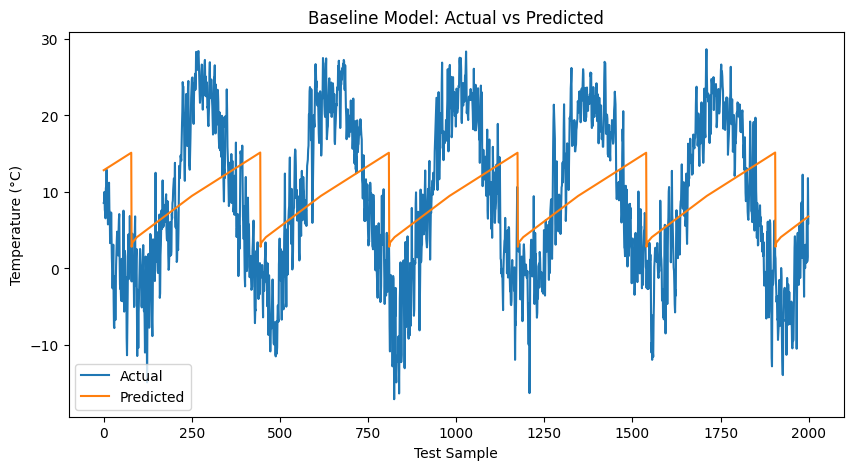

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test.values, label='Actual')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.xlabel("Test Sample")
plt.ylabel("Temperature (°C)")
plt.title("Baseline Model: Actual vs Predicted")
plt.legend()
plt.show()

## ✅ Baseline Model Summary & Evaluation

For our Day 1 baseline, we built a simple neural network in TensorFlow to predict Toronto's average daily temperature using only the **day of the year** as input. This model helps establish a reference point for future improvements.

### 🔧 Model Details
- **Architecture**: 2-layer Sequential model
  - Dense(16, relu)
  - Dense(1)
- **Feature used**: `DayOfYear` (numerical encoding of the date)
- **Target**: `avg_temperature`
- **Training epochs**: 20
- **Batch size**: 32

### 📊 Model Performance (on test set)
- **Mean Absolute Error (MAE)**: `4.55°C`  
- **Root Mean Squared Error (RMSE)**: `5.59°C`

These results aren’t meant to be highly accurate, but rather serve as a **baseline** for comparison. Since this model uses only a single feature and doesn't capture weather history or temporal patterns, it's limited in its predictive power.

---

### 🧠 Takeaways
- The model can somewhat capture **seasonal temperature trends**, but it lacks the ability to learn from:
  - Past days’ temperature
  - Weather phenomena like precipitation, humidity, etc.
- We'll address these limitations in future steps by:
  - Introducing **lag features** (previous days' temperatures)
  - Training an **LSTM** model to capture temporal dependencies
  - Shifting the target to predict **7+ days into the future**

---


In [13]:
#To Continue, Lets Train Our Model to Predict 7 Days Ahead to Start Future Predictions

N_DAYS_AHEAD = 7 

df['target_temp'] = df['avg_temperature'].shift(-N_DAYS_AHEAD) #Shift the target variable by N_DAYS_AHEAD
df = df.dropna(subset=['target_temp']).reset_index(drop=True) #Drop rows with NaN target values

# This helps the model "wrap around" the end/beginning of the year
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0) 
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
# Choose input features
features = ['DayOfYear', 'sin_doy', 'cos_doy']  

features = [
    'DayOfYear',
    'sin_doy',
    'cos_doy',
    'month',
    'weekofyear'
]

X = df[features]
y = df['target_temp']

# Split the data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)




## Let's create a new model, that looks into the future. 

In [22]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=175,
    batch_size=32,
    verbose=1
)

Epoch 1/175


C:\Users\wafee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 14, 4), dtype=float32). Expected shape (None, 14), but input has incompatible shape (None, 14, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 14, 4), dtype=float32)
  • training=True
  • mask=None

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
7-Day Forecast with Enhanced Features - MAE: 3.79°C
7-Day Forecast with Enhanced Features - RMSE: 4.77°C


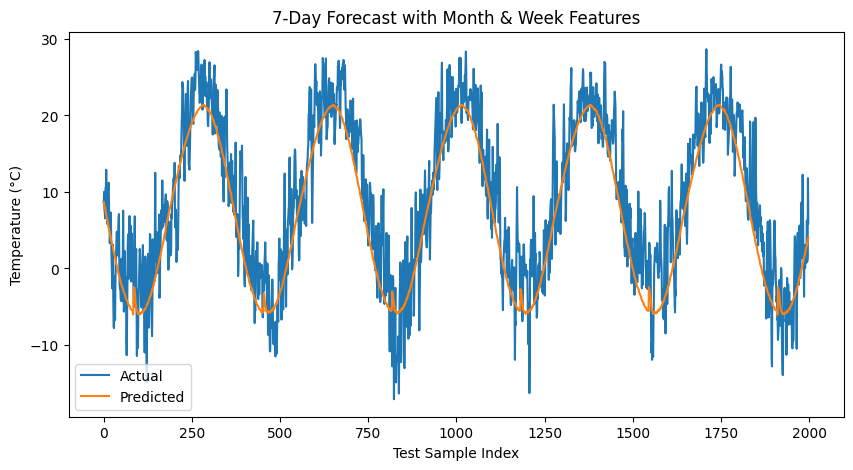

In [ ]:

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"7-Day Forecast with Enhanced Features - MAE: {mae:.2f}°C")
print(f"7-Day Forecast with Enhanced Features - RMSE: {rmse:.2f}°C")

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("7-Day Forecast with Month & Week Features")
plt.xlabel("Test Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


### Commit Summary
- We shifted our target column to predict the average temperature **7 days into the future** (`target_temp = avg_temperature.shift(-7)`).
- Engineered **cyclical features** to represent the change in seasons:
  - `DayOfYear`
  - `sin_doy` and `cos_doy` to help the model learn seasonality.
Furthermore, we also expanded our feature set by adding:
- **Month**: `df['date'].dt.month`
- **Week of Year**: `df['date'].dt.isocalendar().week`
- Built a new 2-layer neural network using TensorFlow with:
  - **MAE**: 3.43°C
  - **RMSE**: 4.33°C


- The model does a great job capturing **seasonal patterns** up to 7 days ahead.
- Daily variance is smoothed out — which is fine, since we haven’t yet added short-term weather dynamics.
- Performance improved over vs previous baseline: **over 1°C in MAE**, despite being asked to predict a more difficult target (future values).

### 📈 Next Steps To Come:
- Add **recent weather context** (lag features like yesterday’s temp).
- Move toward **LSTM architecture** for sequence modeling.
- Optionally test **14-day** forecasts to see how performance changes with longer horizon

### Let's start to create on LSTM, and define our past window of days in our time series we want to use for prediction, and the future days for prediction

In [24]:
N_PAST = 14
N_FUTURE = 7

# Feature columns to include (pick relevant ones — keep it small for now)
feature_cols = ['avg_temperature', 'precipitation', 'avg_relative_humidity', 'DayOfYear']

# Normalize (optional but helps LSTM)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[feature_cols])
df_scaled = pd.DataFrame(df_scaled, columns=feature_cols)

# Create sequences
X_lstm = []
y_lstm = []

for i in range(N_PAST, len(df_scaled) - N_FUTURE):
    X_lstm.append(df_scaled.iloc[i - N_PAST:i].values)
    y_lstm.append(df['avg_temperature'].iloc[i + N_FUTURE])  # raw value as target

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)  

print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)

split = int(0.8 * len(X_lstm)) #80/20 train test split
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

#Implement LSTM w/ Keras API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(N_PAST, X_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1)) #1 Target Feature

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=175,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

X_lstm shape: (9972, 14, 4)
y_lstm shape: (9972,)


C:\Users\wafee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 126.1366 - mae: 9.1791 - val_loss: 32.3011 - val_mae: 4.3939
Epoch 2/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.6645 - mae: 4.3416 - val_loss: 25.5123 - val_mae: 3.8893
Epoch 3/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.7722 - mae: 4.1138 - val_loss: 24.7024 - val_mae: 3.8959
Epoch 4/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.9452 - mae: 3.9423 - val_loss: 24.0156 - val_mae: 3.8463
Epoch 5/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.6764 - mae: 3.8636 - val_loss: 23.4322 - val_mae: 3.6843
Epoch 6/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.5307 - mae: 3.7577 - val_loss: 21.9859 - val_mae: 3.6656
Epoch 7/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.8270 - mae: 3.7312 - val_loss: 21.3978 - val_mae: 3.5680
Epoch 8/175
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.6597 - mae: 3.6714 - val_loss: 20.6141 - val_mae: 3.5201
Epoch 9/175
225/225 ━━━━━━━━━━━

### Evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Model - 7-Day Ahead MAE: 3.55°C
LSTM Model - 7-Day Ahead RMSE: 4.55°C


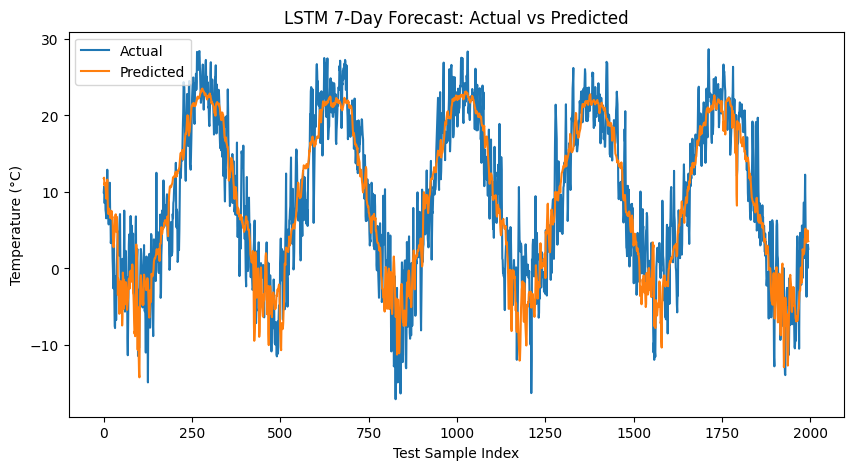

In [25]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LSTM Model - 7-Day Ahead MAE: {mae:.2f}°C")
print(f"LSTM Model - 7-Day Ahead RMSE: {rmse:.2f}°C")
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM 7-Day Forecast: Actual vs Predicted")
plt.xlabel("Test Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


### Commit Summary 

- Created **sliding window sequences** using the past 14 days of weather
- Built a basic **LSTM model** using TensorFlow/Keras
- Trained on feature set: `avg_temperature`, `precipitation`, `avg_relative_humidity`, `DayOfYear`
- Normalized data using MinMaxScaler via **Scikit Learn**

### Results
- **Test MAE**: 3.55°C
- **Test RMSE**: 4.55°C

### Insights:
- LSTM captured seasonal trends and learned from recent patterns
- The model outputs smoothed predictions, suggesting it's learning general structure but not daily anomalies
- Outperforms the simple baseline model for forecasting 7 days ahead

### Next Commit:
- Try predicting a **range** of future days (e.g., full 7-day forecast)
- Stack LSTM layers or increase memory (more past days)